# Question Answering with a Fine-Tuned ELECTRA


# New section

# Part 1: How ELECTRA is applied to Question Answering

## The SQuAD v1.1 Benchmark

When someone mentions "Question Answering" as an application of Electra, what they are really referring to is applying Electra to the Stanford Question Answering Dataset (SQuAD).

The task posed by the SQuAD benchmark is a little different than you might think. Given a question, and *a passage of text containing the answer*, Electra needs to highlight the "span" of text corresponding to the correct answer. 

The SQuAD homepage has a fantastic tool for exploring the questions and reference text for this dataset, and even shows the predictions made by top-performing models.

For example, here are some [interesting examples](https://rajpurkar.github.io/SQuAD-explorer/explore/1.1/dev/Super_Bowl_50.html?model=r-net+%20(ensemble)%20(Microsoft%20Research%20Asia)&version=1.1) on the topic of Super Bowl 50.


## Electra Input Format

To feed a QA task into Electra, we pack both the question and the reference text into the input.


The two pieces of text are separated by the special `[SEP]` token. 

Electra also uses "Segment Embeddings" to differentiate the question from the reference text. These are simply two embeddings (for segments "A" and "B") that Electra learned, and which it adds to the token embeddings before feeding them into the input layer. 

## Start & End Token Classifiers

Electra needs to highlight a "span" of text containing the answer--this is represented as simply predicting which token marks the start of the answer, and which token marks the end.


For every token in the text, we feed its final embedding into the start token classifier. The start token classifier only has a single set of weights (represented by the blue "start" rectangle in the above illustration) which it applies to every word.

After taking the dot product between the output embeddings and the 'start' weights, we apply the softmax activation to produce a probability distribution over all of the words. Whichever word has the highest probability of being the start token is the one that we pick.

We repeat this process for the end token--we have a separate weight vector this.


# Part 2: Example Code

In the example code below, we'll be downloading a model that's *already been fine-tuned* for question answering, and try it out on our own text.

If you do want to fine-tune on your own dataset, it is possible to fine-tune Electra for question answering yourself. See [run_squad.py](https://github.com/huggingface/transformers/blob/master/examples/run_squad.py) in the `transformers` library. However,you may find that the below "fine-tuned-on-squad" model already does a good job, even if your text is from a different domain. 

.

## 1. Install huggingface transformers library

This example uses the `transformers` [library](https://github.com/huggingface/transformers/) by huggingface. We'll start by installing the package.

In [ ]:

import numpy as np # linear algebra
import pandas as pd

In [ ]:
import torch
if torch.cuda.is_available():  
    device = torch.device("cuda")
    print('We will use the GPU:', torch.cuda.get_device_name(0))
    
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

We will use the GPU: Tesla T4


In [ ]:
# Utilities
from time import time
from PIL import Image
from zipfile import ZipFile
import os, sys, itertools, re
import warnings, pickle, string

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Translation APIs

In [ ]:
!pip install transformers

     |████████████████████████████████| 1.4MB 9.0MB/s 
     |████████████████████████████████| 2.9MB 32.2MB/s 
     |████████████████████████████████| 890kB 48.1MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=66cf8538fd1ec695898a73ecb2f37a8dfa970abd0e2d20af2337ebf1d7fa0be4
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
import torch

## 2. Load Fine-Tuned Electra-large

For Question Answering we use the `ElectraForQuestionAnswering` class from the `transformers` library.

This class supports fine-tuning, but for this example we will keep things simpler and load a Electra model that has already been fine-tuned for the SQuAD benchmark.

The `transformers` library has a large collection of pre-trained models which you can reference by name and load easily. The full list is in their documentation [here](https://huggingface.co/transformers/pretrained_models.html).

For Question Answering, they have a version of Electra-large that has already been fine-tuned for the SQuAD benchmark. 

Electra-large is really big... it has 24-layers and an embedding size of 1,024, for a total of 340M parameters! Altogether it is 1.34GB, so expect it to take a couple minutes to download to your Colab instance. 

(Note that this download is not using your own network bandwidth--it's between the Google instance and wherever the model is stored on the web).

Note: I believe this model was trained on version 1 of SQuAD, since it's not outputting whether the question is "impossible" to answer from the text (which is part of the task in v2 of SQuAD).


In [ ]:
from transformers import AutoTokenizer, AutoModelForQuestionAnswering

tokenizer = AutoTokenizer.from_pretrained("ahotrod/electra_large_discriminator_squad2_512")

model= AutoModelForQuestionAnswering.from_pretrained("ahotrod/electra_large_discriminator_squad2_512",return_dict=False)


Load the tokenizer as well. 

Side note: Apparently the vocabulary of this model is identicaly to the one in Electra-base-uncased. You can load the tokenizer from `Electra-base-uncased` and that works just as well.

## 3. Ask a Question

Now we're ready to feed in an example!

A QA example consists of a question and a passage of text containing the answer to that question.

Let's try an example using the text in this tutorial!

In [ ]:
question = r"""How many parameters does Bert-large have?"""
text = r"""Bert-large is really big... it has 24-layers and an embedding size of 1,024, for a total of 340M parameters! Altogether it is 1.34GB, so expect it to take a couple minutes to download to your Colab instance."""

We'll need to run the ELECTRA tokenizer against both the `question` and the `answer_text`. To feed these into ELECTRA, we actually concatenate them together and place the special [SEP] token in between.


In [ ]:
import tensorflow as tf

In [ ]:
input_text=question+"[SEP]"+text
inputs = tokenizer(question, text, add_special_tokens=True, return_tensors="pt")
input_ids = inputs["input_ids"].tolist()[0] 
print(input)
print(input_ids)



<bound method Kernel.raw_input of <google.colab._kernel.Kernel object at 0x7fa2c8e563c8>>
[101, 2129, 2116, 11709, 2515, 14324, 1011, 2312, 2031, 1029, 102, 14324, 1011, 2312, 2003, 2428, 2502, 1012, 1012, 1012, 2009, 2038, 2484, 1011, 9014, 1998, 2019, 7861, 8270, 4667, 2946, 1997, 1015, 1010, 6185, 2549, 1010, 2005, 1037, 2561, 1997, 16029, 2213, 11709, 999, 10462, 2009, 2003, 1015, 1012, 4090, 18259, 1010, 2061, 5987, 2009, 2000, 2202, 1037, 3232, 2781, 2000, 8816, 2000, 2115, 15270, 2497, 6013, 1012, 102]


In [ ]:
text_tokens = tokenizer.convert_ids_to_tokens(input_ids) # Get the tokens for the question + context
answer_start_scores, answer_end_scores = model(**inputs)
    

In [ ]:
answer_start = torch.argmax(answer_start_scores)  # Get the most likely beginning of answer with the argmax of the score
answer_end = torch.argmax(answer_end_scores) + 1  # Get the most likely end of answer with the argmax of the score
# Combine the tokens in the answer and print it out.
answer = ' '.join(text_tokens[answer_start:answer_end+1])

print('Answer: "' + answer + '"')

Answer: "340 ##m parameters"


In [ ]:
answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(input_ids[answer_start:answer_end]))
    
print(f"Question: {question}")
print(f"Answer: {answer}")

Question: How many parameters does Bert-large have?
Answer: 340m


It got it right! Awesome :)

> *Side Note: It's a little naive to pick the highest scores for start and end--what if it predicts an end word that's before the start word?! The correct implementation is to pick the highest total score for which end >= start.*

With a little more effort, we can reconstruct any words that got broken down into subwords.

In [ ]:
# Start with the first token.
answer = text_tokens[answer_start]

# Select the remaining answer tokens and join them with whitespace.
for i in range(answer_start + 1, answer_end + 1):
    
    # If it's a subword token, then recombine it with the previous token.
    if text_tokens[i][0:2] == '##':
        answer += text_tokens[i][2:]
    
    # Otherwise, add a space then the token.
    else:
        answer += ' ' + text_tokens[i]

print('Answer: "' + answer + '"')

Answer: "340m parameters"


## 4. Visualizing Scores

I was curious to see what the scores were for all of the words. The following cells generate bar plots showing the start and end scores for every word in the input.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
#sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (16,8)

Retrieve all of the start and end scores, and use all of the tokens as x-axis labels.

In [ ]:
# Pull the scores out of PyTorch Tensors and convert them to 1D numpy arrays.
s_scores = answer_start_scores.detach().numpy().flatten()
e_scores = answer_end_scores.detach().numpy().flatten()

# We'll use the tokens as the x-axis labels. In order to do that, they all need
# to be unique, so we'll add the token index to the end of each one.
token_labels = []
for (i, text_token) in enumerate(text_tokens):
    token_labels.append('{:} - {:>2}'.format(text_token, i))


Create a bar plot showing the score for every input word being the "start" word.

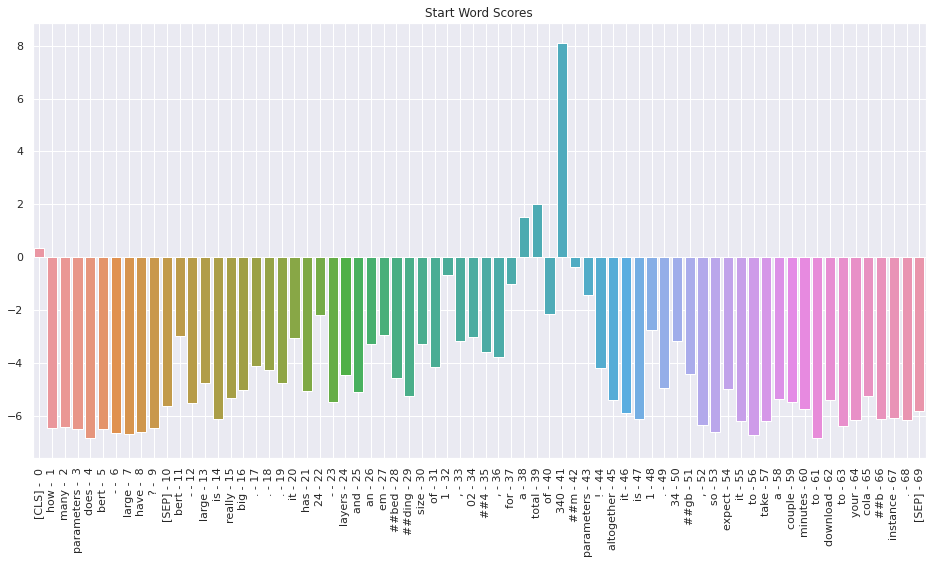

In [ ]:
# Create a barplot showing the start word score for all of the tokens.
ax = sns.barplot(x=token_labels, y=s_scores, ci=None)

# Turn the xlabels vertical.
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")

# Turn on the vertical grid to help align words to scores.
ax.grid(True)

plt.title('Start Word Scores')

plt.show()

Create a second bar plot showing the score for every input word being the "end" word.

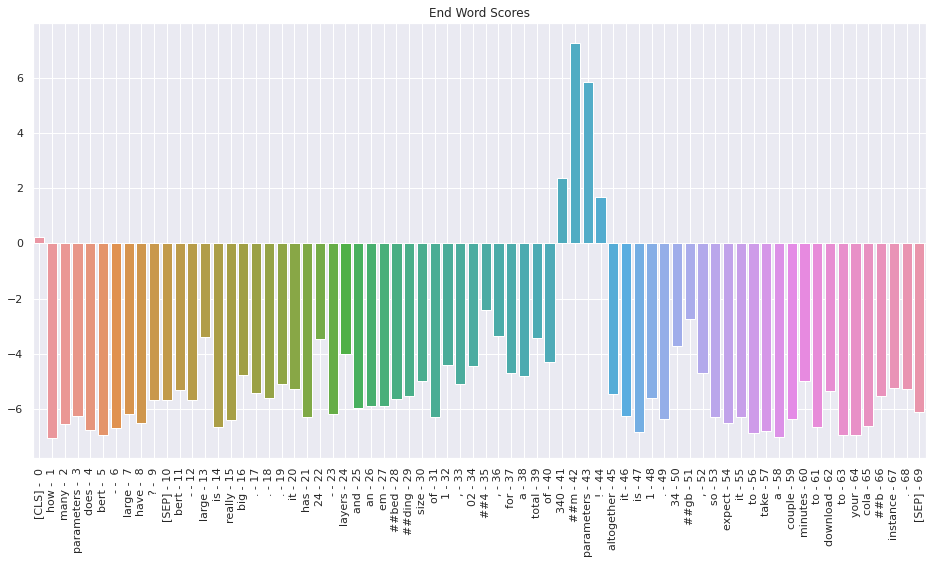

In [ ]:
# Create a barplot showing the end word score for all of the tokens.
ax = sns.barplot(x=token_labels, y=e_scores, ci=None)

# Turn the xlabels vertical.
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")

# Turn on the vertical grid to help align words to scores.
ax.grid(True)

plt.title('End Word Scores')

plt.show()

**Alternate View**

I also tried visualizing both the start and end scores on a single bar plot, but I think it may actually be more confusing then seeing them separately. 

In [ ]:
import pandas as pd

# Store the tokens and scores in a DataFrame. 
# Each token will have two rows, one for its start score and one for its end
# score. The "marker" column will differentiate them. A little wacky, I know.
scores = []
for (i, token_label) in enumerate(token_labels):

    # Add the token's start score as one row.
    scores.append({'token_label': token_label, 
                   'score': s_scores[i],
                   'marker': 'start'})
    
    # Add  the token's end score as another row.
    scores.append({'token_label': token_label, 
                   'score': e_scores[i],
                   'marker': 'end'})
    
df = pd.DataFrame(scores)


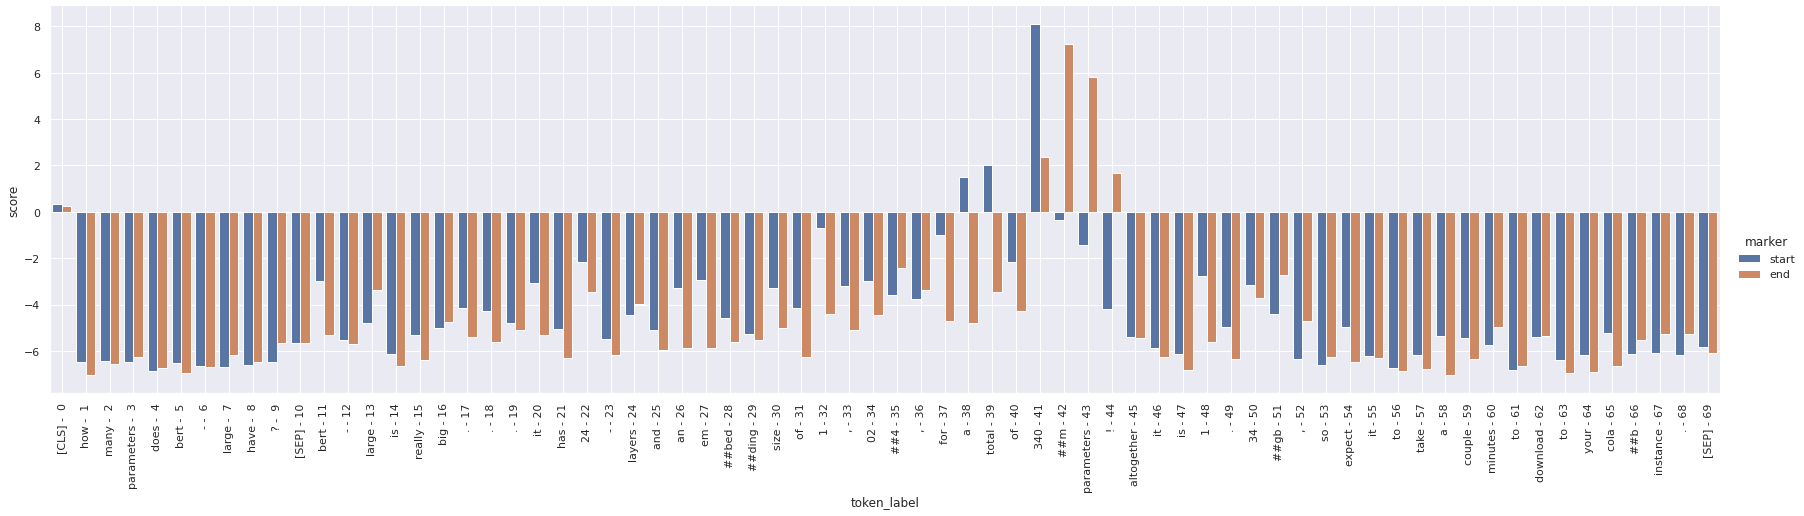

In [ ]:
# Draw a grouped barplot to show start and end scores for each word.
# The "hue" parameter is where we tell it which datapoints belong to which
# of the two series.
g = sns.catplot(x="token_label", y="score", hue="marker", data=df,
                kind="bar", height=6, aspect=4)

# Turn the xlabels vertical.
g.set_xticklabels(g.ax.get_xticklabels(), rotation=90, ha="center")

# Turn on the vertical grid to help align words to scores.
g.ax.grid(True)


## 5. More Examples

Turn the QA process into a function so we can easily try out other examples.

In [ ]:
def answer_question(question, text):

  inputs = tokenizer(question, text, add_special_tokens=True, return_tensors="pt")
  input_ids = inputs["input_ids"].tolist()[0] # the list of all indices of words in question + context
    
  text_tokens = tokenizer.convert_ids_to_tokens(input_ids) # Get the tokens for the question + context
  answer_start_scores, answer_end_scores = model(**inputs)
    
  answer_start = torch.argmax(answer_start_scores)  # Get the most likely beginning of answer with the argmax of the score
  answer_end = torch.argmax(answer_end_scores) + 1  # Get the most likely end of answer with the argmax of the score
    
  answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(input_ids[answer_start:answer_end]))
    
  print(f"Question: {question}")
  print(f"Answer: {answer}")
    


As our reference text, I've taken the Abstract of the [BERT paper](https://arxiv.org/pdf/1810.04805.pdf).


In [ ]:
import textwrap

# Wrap text to 80 characters.
wrapper = textwrap.TextWrapper(width=80) 

bert_abstract = "We introduce a new language representation model called BERT, which stands for Bidirectional Encoder Representations from Transformers. Unlike recent language representation models (Peters et al., 2018a; Radford et al., 2018), BERT is designed to pretrain deep bidirectional representations from unlabeled text by jointly conditioning on both left and right context in all layers. As a result, the pre-trained BERT model can be finetuned with just one additional output layer to create state-of-the-art models for a wide range of tasks, such as question answering and language inference, without substantial taskspecific architecture modifications. BERT is conceptually simple and empirically powerful. It obtains new state-of-the-art results on eleven natural language processing tasks, including pushing the GLUE score to 80.5% (7.7% point absolute improvement), MultiNLI accuracy to 86.7% (4.6% absolute improvement), SQuAD v1.1 question answering Test F1 to 93.2 (1.5 point absolute improvement) and SQuAD v2.0 Test F1 to 83.1 (5.1 point absolute improvement)."

print(wrapper.fill(bert_abstract))

We introduce a new language representation model called BERT, which stands for
Bidirectional Encoder Representations from Transformers. Unlike recent language
representation models (Peters et al., 2018a; Radford et al., 2018), BERT is
designed to pretrain deep bidirectional representations from unlabeled text by
jointly conditioning on both left and right context in all layers. As a result,
the pre-trained BERT model can be finetuned with just one additional output
layer to create state-of-the-art models for a wide range of tasks, such as
question answering and language inference, without substantial taskspecific
architecture modifications. BERT is conceptually simple and empirically
powerful. It obtains new state-of-the-art results on eleven natural language
processing tasks, including pushing the GLUE score to 80.5% (7.7% point absolute
improvement), MultiNLI accuracy to 86.7% (4.6% absolute improvement), SQuAD v1.1
question answering Test F1 to 93.2 (1.5 point absolute improvement) 

-----------------------------
Ask ELECTRA what BERT name stands for (the answer is in the first sentence of the abstract).

In [ ]:
question = "What does the 'B' in BERT stand for?"

answer_question(question, bert_abstract)

Question: What does the 'B' in BERT stand for?
Answer: bidirectional encoder representations from transformers


---------------------
Ask ELECTRA about example applications of BERT :)

The answer to the question comes from this passage from the abstract: 

> "...BERT model can be finetuned with just one additional output
layer to create state-of-the-art models for **a wide range of tasks, such as
question answering and language inference,** without substantial taskspecific
architecture modifications."

In [ ]:
question = "What are some example applications of BERT?"

answer_question(question, bert_abstract)

Question: What are some example applications of BERT?
Answer: question answering and language inference
